In [2]:
from datetime import date
import statistics
from collections import Counter
import os

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from pandas.plotting import table 
import matplotlib.pyplot as plt
import matplotlib.table as table
import seaborn as sns
from scipy import stats

In [3]:
repos = pd.read_csv("../collect_repositories/results/repositories_filtered_2021-11-04.csv")
how_fair_is = pd.read_csv("output/repositories_howfairis.csv")
languages = pd.read_csv("output/languages_2021-05-22.csv")
contributors = pd.read_csv("output/contributors_2021-06-11.csv")
topics = pd.read_csv("output/topics_2021-06-04.csv")
export_path_graphs = "../graphs/"

## Filtering for research groups or private users only

In [9]:
users = pd.read_excel("../collect_users/unique_users_annotated.xlsx")

In [10]:
def add_research_group_filter(dataset):
    user_is_research_group = []
    for row in dataset.iterrows():
        try:
            owner = row[1]['owner']
        except:
            owner = row[1]['html_url_repository'].split('/')[-2]
            
            
      
        row_users = users.loc[users['user_id'] == owner]
        if len(row_users['is_research_group']) == 0:
            user_is_research_group.append(False)
        for i in row_users['is_research_group']:
            if i == 1:
                user_is_research_group.append(True)
                break
            else:
                user_is_research_group.append(False)
                break
                    
    return user_is_research_group
    

In [15]:
repos['is_research_group'] = add_research_group_filter(repos)
contributors['is_research_group'] = add_research_group_filter(contributors)
topics['is_research_group'] = add_research_group_filter(topics)
languages['is_research_group'] = add_research_group_filter(languages)
how_fair_is['is_research_group'] = add_research_group_filter(how_fair_is)

## Run to filter for only private users

In [6]:
repos = repos[~repos['is_research_group']]
contributors = contributors[~contributors['is_research_group']]
topics = topics[~topics['is_research_group']]
languages = languages[~languages['is_research_group']]
how_fair_is = how_fair_is[~how_fair_is['is_research_group']]
export_path_graphs = '../private_user_graphs/'

## Run to filter for only research groups

In [7]:
repos = repos[repos['is_research_group']]
contributors = contributors[contributors['is_research_group']]
topics = topics[topics['is_research_group']]
languages = languages[languages['is_research_group']]
how_fair_is = how_fair_is[how_fair_is['is_research_group']]
export_path_graphs = '../research_group_graphs/'

### Run to create folders if they don't exist

In [22]:
if not os.path.isdir(export_path_graphs):
    os.makedirs(export_path_graphs)

## Datasets

Using the github API and the Howfairis software, we collected data on the repositories, their FAIRness, the languages used in the repository, the amount of contributors for each repository and the topics mentoined in each repository. 

The Howfairis software gives  boolean value on five measures of FAIRness for each repository. These five measures consist of having a repository (which is always True for our dataset), having a license, being available in a registry, allowing citation of the software and following the FAIR software quality checklist. Below, the first five rows of the datasets are displayed. 

In [16]:
repos

id                           node_id                     name  \
0     307429416  MDEwOlJlcG9zaXRvcnkzMDc0Mjk0MTY=              fastlogitME   
1      73220408  MDEwOlJlcG9zaXRvcnk3MzIyMDQwOA==  Seattle-Feature-Service   
2     259872452  MDEwOlJlcG9zaXRvcnkyNTk4NzI0NTI=           choropleth_map   
3     112259672  MDEwOlJlcG9zaXRvcnkxMTIyNTk2NzI=     Live_Earthquake_Feed   
4      51859197  MDEwOlJlcG9zaXRvcnk1MTg1OTE5Nw==               MyLocation   
...         ...                               ...                      ...   
1351   42170154  MDEwOlJlcG9zaXRvcnk0MjE3MDE1NA==              brokenstick   
1352  360871593  MDEwOlJlcG9zaXRvcnkzNjA4NzE1OTM=            jamesdemodata   
1353  337202059  MDEwOlJlcG9zaXRvcnkzMzcyMDIwNTk=                  centile   
1354  347425843  MDEwOlJlcG9zaXRvcnkzNDc0MjU4NDM=                bdsreader   
1355   64665105  MDEwOlJlcG9zaXRvcnk2NDY2NTEwNQ==                 aglcheck   

                             full_name  private          owner  \
0                  M-thieu/fastlogitME    False        M-thieu   
1     bricker0/Seattle-Feature-Service    False       bricker0   
2              bricker0/choropleth_map    False       bricker0   
3        bricker0/Live_Earthquake_Feed    False       bricker0   
4                  bricker0/MyLocation    False       bricker0   
...                                ...      ...            ...   
1351          growthcharts/brokenstick    False   growthcharts   
1352        growthcharts/jamesdemodata    False   growthcharts   
1353              growthcharts/centile    False   growthcharts   
1354            growthcharts/bdsreader    False   growthcharts   
1355            gjlbeckers-uu/aglcheck    False  gjlbeckers-uu   

                                               html_url  \
0                https://github.com/M-thieu/fastlogitME   
1     https://github.com/bricker0/Seattle-Feature-Se...   
2            https://github.com/bricker0/choropleth_map   
3      https://github.com/bricker0/Live_Earthquake_Feed   
4                https://github.com/bricker0/MyLocation   
...                                                 ...   
1351        https://github.com/growthcharts/brokenstick   
1352      https://github.com/growthcharts/jamesdemodata   
1353            https://github.com/growthcharts/centile   
1354          https://github.com/growthcharts/bdsreader   
1355          https://github.com/gjlbeckers-uu/aglcheck   

                                            description   fork  \
0     Fast but Basic Marginal Effects for Logit Mode...  False   
1     Here I explain how to call Seattle Open Data E...  False   
2     How to make a choropleth map using SDG indicat...  False   
3     Want to make one of those snazzy live Earthqua...  False   
4                                                 Lab 3  False   
...                                                 ...    ...   
1351  Broken Stick Model for Irregular Longitudinal ...  False   
1352                                Demo Data for JAMES  False   
1353  Translate Measurements, Z-Scores and Centiles ...  False   
1354  Read Data from the Basisdataset Jeugdgezondhei...  False   
1355  aglcheck is a python library for analyzing non...  False   

                                                    url  ...  \
0      https://api.github.com/repos/M-thieu/fastlogitME  ...   
1     https://api.github.com/repos/bricker0/Seattle-...  ...   
2     https://api.github.com/repos/bricker0/chorople...  ...   
3     https://api.github.com/repos/bricker0/Live_Ear...  ...   
4      https://api.github.com/repos/bricker0/MyLocation  ...   
...                                                 ...  ...   
1351  https://api.github.com/repos/growthcharts/brok...  ...   
1352  https://api.github.com/repos/growthcharts/jame...  ...   
1353  https://api.github.com/repos/growthcharts/centile  ...   
1354  https://api.github.com/repos/growthcharts/bdsr...  ...   
1355  https://api.github.com/repos/gjlbeckers-uu/agl...  ...   

     open_is

In [17]:
how_fair_is

id                           node_id                     name  \
0     307429416  MDEwOlJlcG9zaXRvcnkzMDc0Mjk0MTY=              fastlogitME   
1      73220408  MDEwOlJlcG9zaXRvcnk3MzIyMDQwOA==  Seattle-Feature-Service   
2     259872452  MDEwOlJlcG9zaXRvcnkyNTk4NzI0NTI=           choropleth_map   
3     112259672  MDEwOlJlcG9zaXRvcnkxMTIyNTk2NzI=     Live_Earthquake_Feed   
4      51859197  MDEwOlJlcG9zaXRvcnk1MTg1OTE5Nw==               MyLocation   
...         ...                               ...                      ...   
1351   42170154  MDEwOlJlcG9zaXRvcnk0MjE3MDE1NA==              brokenstick   
1352  360871593  MDEwOlJlcG9zaXRvcnkzNjA4NzE1OTM=            jamesdemodata   
1353  337202059  MDEwOlJlcG9zaXRvcnkzMzcyMDIwNTk=                  centile   
1354  347425843  MDEwOlJlcG9zaXRvcnkzNDc0MjU4NDM=                bdsreader   
1355   64665105  MDEwOlJlcG9zaXRvcnk2NDY2NTEwNQ==                 aglcheck   

                             full_name  private          owner  \
0                  M-thieu/fastlogitME    False        M-thieu   
1     bricker0/Seattle-Feature-Service    False       bricker0   
2              bricker0/choropleth_map    False       bricker0   
3        bricker0/Live_Earthquake_Feed    False       bricker0   
4                  bricker0/MyLocation    False       bricker0   
...                                ...      ...            ...   
1351          growthcharts/brokenstick    False   growthcharts   
1352        growthcharts/jamesdemodata    False   growthcharts   
1353              growthcharts/centile    False   growthcharts   
1354            growthcharts/bdsreader    False   growthcharts   
1355            gjlbeckers-uu/aglcheck    False  gjlbeckers-uu   

                                               html_url  \
0                https://github.com/M-thieu/fastlogitME   
1     https://github.com/bricker0/Seattle-Feature-Se...   
2            https://github.com/bricker0/choropleth_map   
3      https://github.com/bricker0/Live_Earthquake_Feed   
4                https://github.com/bricker0/MyLocation   
...                                                 ...   
1351        https://github.com/growthcharts/brokenstick   
1352      https://github.com/growthcharts/jamesdemodata   
1353            https://github.com/growthcharts/centile   
1354          https://github.com/growthcharts/bdsreader   
1355          https://github.com/gjlbeckers-uu/aglcheck   

                                            description   fork  \
0     Fast but Basic Marginal Effects for Logit Mode...  False   
1     Here I explain how to call Seattle Open Data E...  False   
2     How to make a choropleth map using SDG indicat...  False   
3     Want to make one of those snazzy live Earthqua...  False   
4                                                 Lab 3  False   
...                                                 ...    ...   
1351  Broken Stick Model for Irregular Longitudinal ...  False   
1352                                Demo Data for JAMES  False   
1353  Translate Measurements, Z-Scores and Centiles ...  False   
1354  Read Data from the Basisdataset Jeugdgezondhei...  False   
1355  aglcheck is a python library for analyzing non...  False   

                                                    url  ... watchers  \
0      https://api.github.com/repos/M-thieu/fastlogitME  ...        0   
1     https://api.github.com/repos/bricker0/Seattle-...  ...        2   
2     https://api.github.com/repos/bricker0/chorople...  ...        1   
3     https://api.github.com/repos/bricker0/Live_Ear...  ...        0   
4      https://api.github.com/repos/bricker0/MyLocation  ...        0   
...                                                 ...  ...      ...   
1351  https://api.github.com/repos/growthcharts/brok...  ...        4   
1352  https://api.github.com/repos/growthcharts/jame...  ...        0   
1353  https://api.github.com/repos/growthcharts/centile  ...        0   
1354  https://api.github.com/repos/growthcharts/bds

In [18]:
languages

html_url_repository          language  \
0                https://github.com/M-thieu/fastlogitME                 R   
1     https://github.com/bricker0/Seattle-Feature-Se...              HTML   
2                https://github.com/bricker0/MyLocation             Swift   
3              https://github.com/bricker0/Leaflet_2017              HTML   
4              https://github.com/bricker0/BasicWebsite               CSS   
...                                                 ...               ...   
2779          https://github.com/gjlbeckers-uu/aglcheck              HTML   
2780          https://github.com/gjlbeckers-uu/aglcheck  Jupyter Notebook   
2781          https://github.com/gjlbeckers-uu/aglcheck            Python   
2782          https://github.com/gjlbeckers-uu/aglcheck         Batchfile   
2783          https://github.com/gjlbeckers-uu/aglcheck             Shell   

      num_chars  is_research_group  
0          9917              False  
1          7296              False  
2         22906              False  
3          5028              False  
4           922              False  
...         ...                ...  
2779    1242261              False  
2780     643501              False  
2781     128191              False  
2782         50              False  
2783         44              False  

[2784 rows x 4 columns]

In [28]:
contributors

html_url_repository          login  \
0                https://github.com/M-thieu/fastlogitME        M-thieu   
1     https://github.com/bricker0/Seattle-Feature-Se...       bricker0   
2            https://github.com/bricker0/choropleth_map       bricker0   
3      https://github.com/bricker0/Live_Earthquake_Feed       bricker0   
4                https://github.com/bricker0/MyLocation       bricker0   
...                                                 ...            ...   
3119        https://github.com/growthcharts/brokenstick  stefvanbuuren   
3120      https://github.com/growthcharts/jamesdemodata  stefvanbuuren   
3121            https://github.com/growthcharts/centile  stefvanbuuren   
3122          https://github.com/growthcharts/bdsreader  stefvanbuuren   
3123          https://github.com/gjlbeckers-uu/aglcheck       gbeckers   

            id               node_id  \
0     20308204  MDQ6VXNlcjIwMzA4MjA0   
1      1919662  MDQ6VXNlcjE5MTk2NjI=   
2      1919662  MDQ6VXNlcjE5MTk2NjI=   
3      1919662  MDQ6VXNlcjE5MTk2NjI=   
4      1919662  MDQ6VXNlcjE5MTk2NjI=   
...        ...                   ...   
3119   3919919  MDQ6VXNlcjM5MTk5MTk=   
3120   3919919  MDQ6VXNlcjM5MTk5MTk=   
3121   3919919  MDQ6VXNlcjM5MTk5MTk=   
3122   3919919  MDQ6VXNlcjM5MTk5MTk=   
3123  12132492  MDQ6VXNlcjEyMTMyNDky   

                                             avatar_url  gravatar_id  \
0     https://avatars.githubusercontent.com/u/203082...          NaN   
1     https://avatars.githubusercontent.com/u/191966...          NaN   
2     https://avatars.githubusercontent.com/u/191966...          NaN   
3     https://avatars.githubusercontent.com/u/191966...          NaN   
4     https://avatars.githubusercontent.com/u/191966...          NaN   
...                                                 ...          ...   
3119  https://avatars.githubusercontent.com/u/391991...          NaN   
3120  https://avatars.githubusercontent.com/u/391991...          NaN   
3121  https://avatars.githubusercontent.com/u/391991...          NaN   
3122  https://avatars.githubusercontent.com/u/391991...          NaN   
3123  https://avatars.githubusercontent.com/u/121324...          NaN   

                                             url  \
0           https://api.github.com/users/M-thieu   
1          https://api.github.com/users/bricker0   
2          https://api.github.com/users/bricker0   
3          https://api.github.com/users/bricker0   
4          https://api.github.com/users/bricker0   
...                                          ...   
3119  https://api.github.com/users/stefvanbuuren   
3120  https://api.github.com/users/stefvanbuuren   
3121  https://api.github.com/users/stefvanbuuren   
3122  https://api.github.com/users/stefvanbuuren   
3123       https://api.github.com/users/gbeckers   

                              html_url  \
0           https://github.com/M-thieu   
1          https://github.com/bricker0   
2          https://github.com/bricker0   
3          https://github.com/bricker0   
4          https://github.com/bricker0   
...                                ...   
3119  https://github.com/stefvanbuuren   
3120  https://github.com/stefvanbuuren   
3121  https://github.com/stefvanbuuren   
3122  https://github.com/stefvanbuuren   
3123       https://github.com/gbeckers   

                                          followers_url  \
0        https://api.github.com/users/M-thieu/followers   
1       https://api.github.com/users/bricker0/followers   
2       https://api.github.com/users/bricker0/followers   
3       https://api.github.com/users/bricker0/followers   
4       https://api.github.com/users/bricker0/followers   
...                                                 ...   
3119  https://api.github.com/users/stefvanbuuren/fol...   
3120  https://api.github.com/users/stefvanbuuren/fol...   
3121  https://api.github.com/users/stefvanbuuren/fol...   
3122  https://api.github.com/users/stefvanbuuren/fol...   
3123    https://api.gi

In [29]:
topics

html_url_repository             topic  \
0        https://github.com/cjvanlissa/COVID19_metadata              ncov   
1        https://github.com/cjvanlissa/COVID19_metadata       coronavirus   
2        https://github.com/cjvanlissa/COVID19_metadata             covid   
3        https://github.com/cjvanlissa/COVID19_metadata        sars-cov-2   
4     https://github.com/UUDigitalHumanitieslab/texc...            python   
...                                                 ...               ...   
1203            https://github.com/growthcharts/centile      james-server   
1204            https://github.com/growthcharts/centile           centile   
1205          https://github.com/growthcharts/bdsreader              json   
1206          https://github.com/growthcharts/bdsreader      james-server   
1207          https://github.com/growthcharts/bdsreader  basisdataset-jgz   

      is_research_group  
0                 False  
1                 False  
2                 False  
3                 False  
4                  True  
...                 ...  
1203               True  
1204               True  
1205               True  
1206               True  
1207               True  

[1208 rows x 3 columns]

In [19]:
print("The repository data from Github contains the following columns:")
print(repos.columns)

The repository data from Github contains the following columns:
Index(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'html_url',
       'description', 'fork', 'url', 'forks_url', 'keys_url',
       'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url',
       'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url',
       'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url',
       'languages_url', 'stargazers_url', 'contributors_url',
       'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url',
       'comments_url', 'issue_comment_url', 'contents_url', 'compare_url',
       'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url',
       'milestones_url', 'notifications_url', 'labels_url', 'releases_url',
       'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url',
       'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size',
       'stargazers_count', 'watchers_count', 'language', 'has_i

## Different licenses 

A license is important because it shows that people have permission to use and modify your code. In our dataset,the most common one is MIT license, followed by GNU General Public license.  The plot below shows the value count of different licenses. 


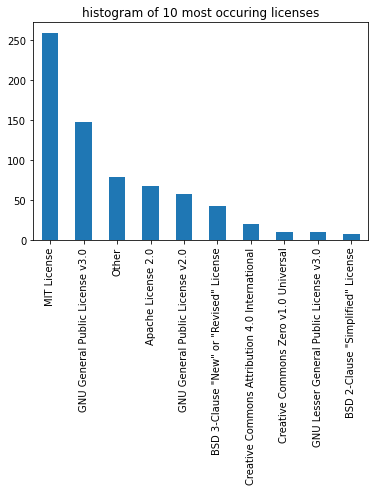

In [23]:
#first 10 licences
repos["license"].value_counts().head(10).plot(kind='bar', title='histogram of 10 most occuring licenses')
plt.savefig(export_path_graphs + "licenses_first10.png" ,bbox_inches="tight")

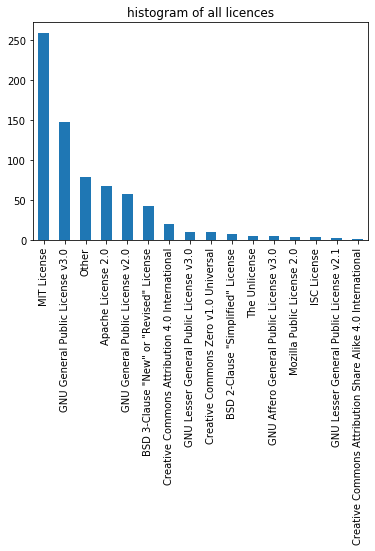

In [32]:
#all licences
repos["license"].value_counts().plot(kind='bar', title = 'histogram of all licences')
plt.savefig(export_path_graphs + "licenses_all.png" ,bbox_inches="tight")

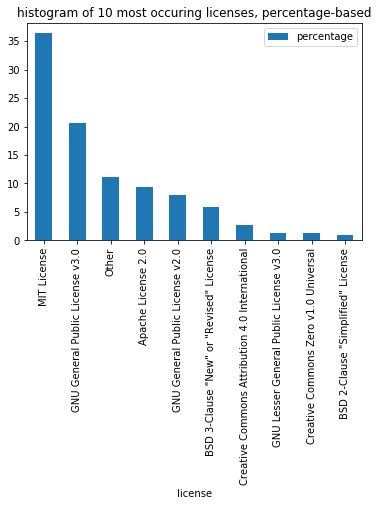

In [265]:
value_count_licenses  = repos["license"].value_counts().head(10)
percentage_count_licences = [[license, value_count/repos["license"].value_counts().sum()*100] for value_count,license in zip(value_count_licenses,value_count_licenses.keys())]
percentage_pd = pd.DataFrame(percentage_count_licences, columns = ['license','percentage'])
percentage_pd  = percentage_pd.set_index('license')
percentage_pd.plot(kind='bar', title='histogram of 10 most occuring licenses, percentage-based')
plt.savefig(export_path_graphs + "licenses_percentages.png" ,bbox_inches="tight")


Below, the propotion of licenses compared to the total is shown, with their absolute count shown below that. . 

In [33]:

for key,i in zip(repos["license"].value_counts().keys(), repos["license"].value_counts()):
    print(key + '{}: {:.3f}'.format(key, i/sum(repos["license"].value_counts())))
    #print(i/sum(repos["license"].value_counts()))


MIT LicenseMIT License: 0.364
GNU General Public License v3.0GNU General Public License v3.0: 0.206
OtherOther: 0.111
Apache License 2.0Apache License 2.0: 0.094
GNU General Public License v2.0GNU General Public License v2.0: 0.080
BSD 3-Clause "New" or "Revised" LicenseBSD 3-Clause "New" or "Revised" License: 0.059
Creative Commons Attribution 4.0 InternationalCreative Commons Attribution 4.0 International: 0.027
GNU Lesser General Public License v3.0GNU Lesser General Public License v3.0: 0.013
Creative Commons Zero v1.0 UniversalCreative Commons Zero v1.0 Universal: 0.013
BSD 2-Clause "Simplified" LicenseBSD 2-Clause "Simplified" License: 0.010
The UnlicenseThe Unlicense: 0.006
GNU Affero General Public License v3.0GNU Affero General Public License v3.0: 0.006
Mozilla Public License 2.0Mozilla Public License 2.0: 0.004
ISC LicenseISC License: 0.004
GNU Lesser General Public License v2.1GNU Lesser General Public License v2.1: 0.003
Creative Commons Attribution Share Alike 4.0 Interna

In [35]:
repos["license"].value_counts().to_excel('license_names.xlsx')


In [36]:
percentage_license = int(repos["license"].isna().value_counts()[1]/len(repos)* 100)
print("{} % of repositories have any kind of license on their page ".format(percentage_license))

47 % of repositories have any kind of license on their page 


## Languages

The programming language that is used in the repository gives information on the type of project the repository is. data analysis is mostly done in R and Python, though Python is used for other purposes as well. 

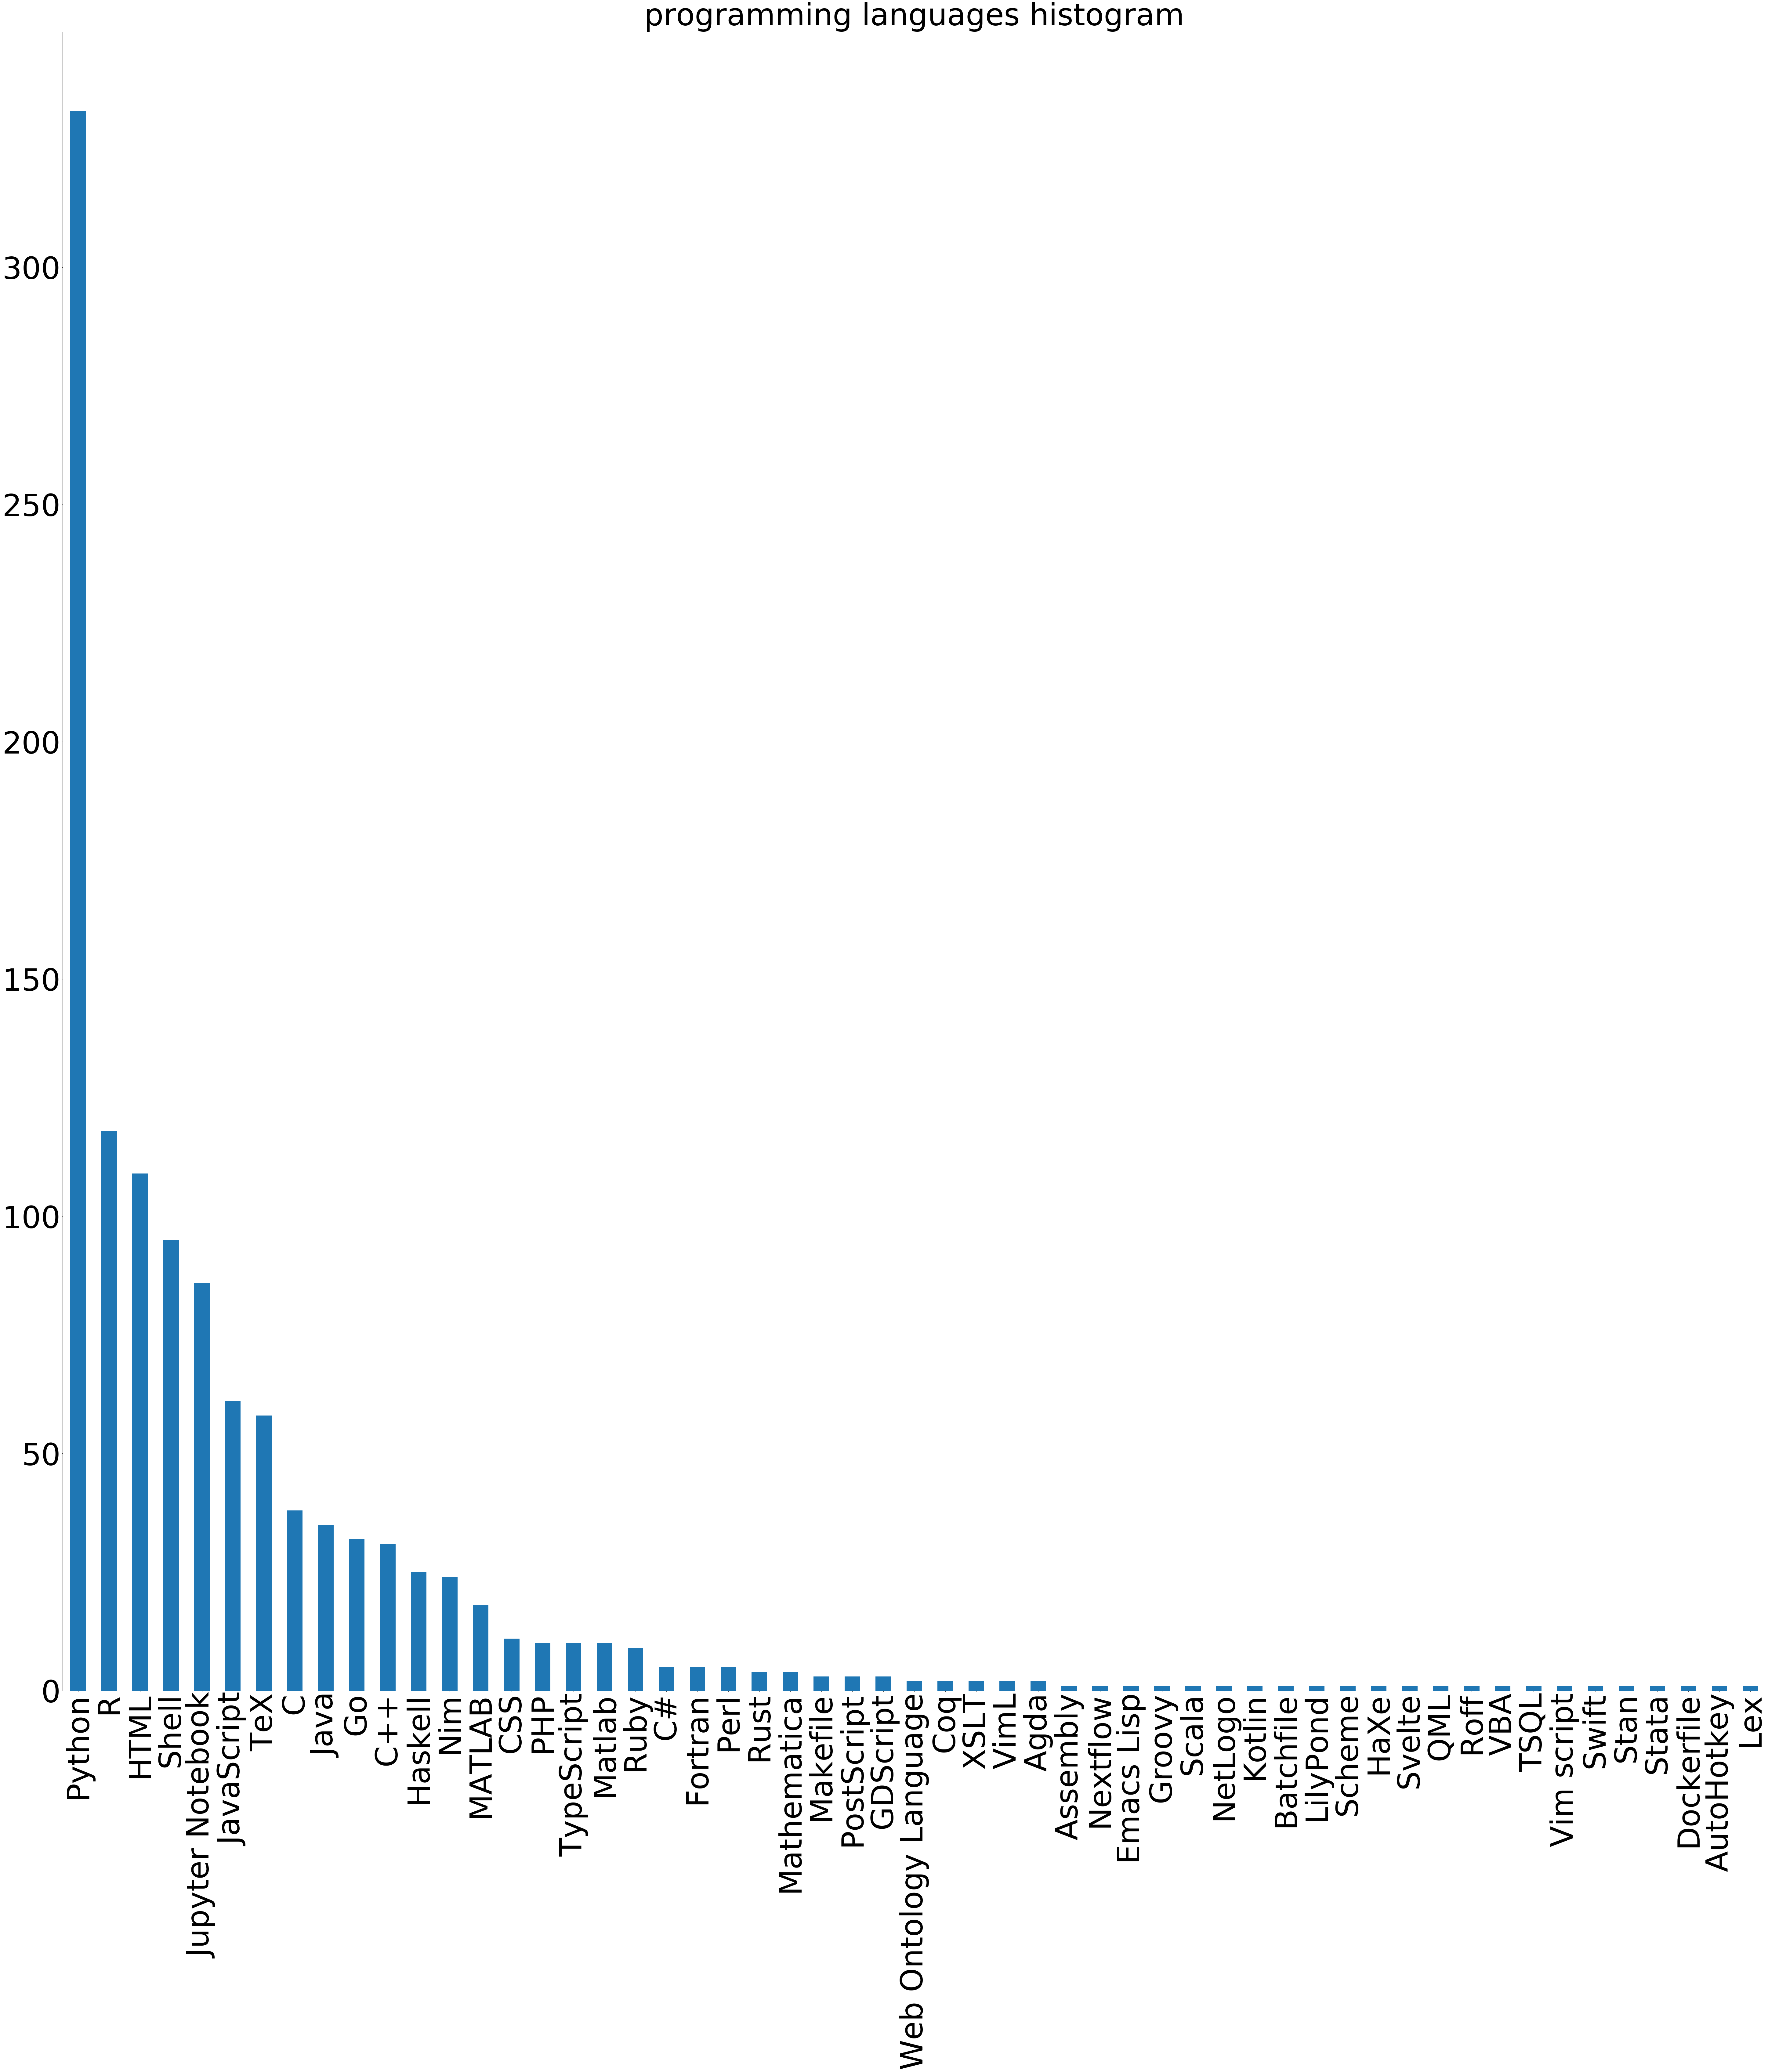

In [38]:
repos["language"].value_counts().plot(kind='bar', figsize = (100,100), fontsize = 100)
plt.title("programming languages histogram", fontsize = 100)
plt.savefig(export_path_graphs + '/language_plot.png')

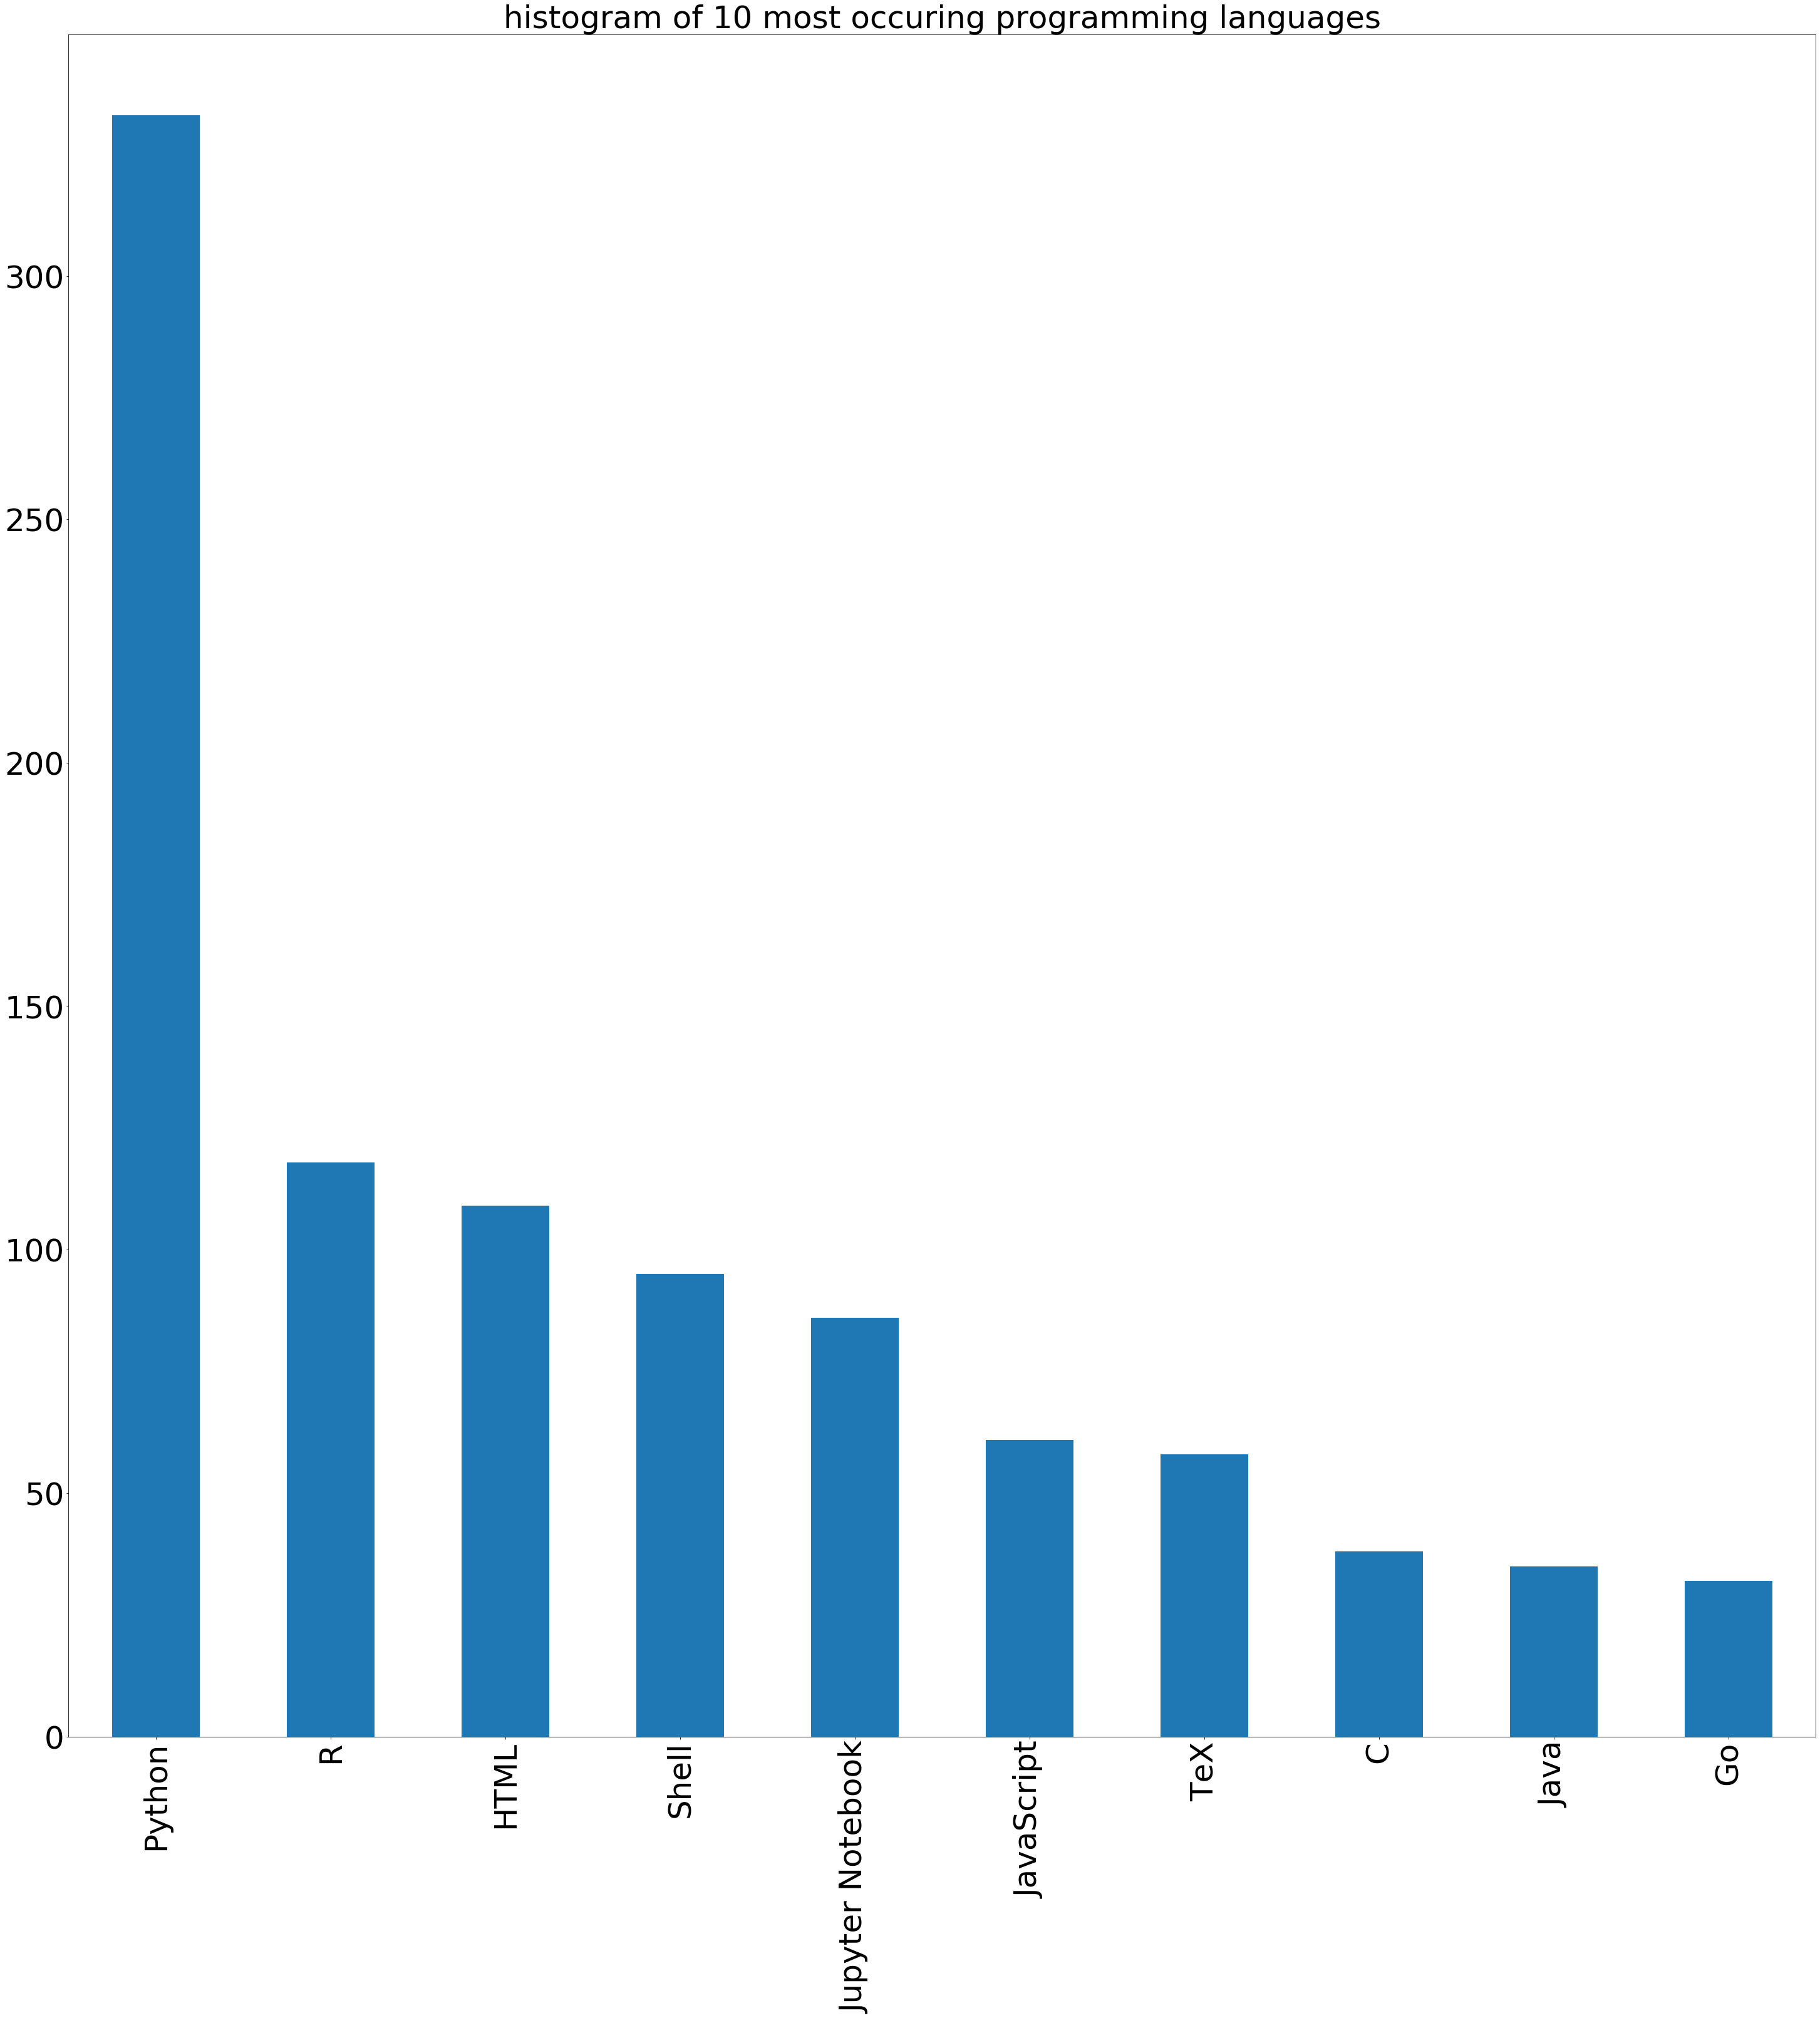

In [39]:
repos["language"].value_counts().head(10).plot(kind='bar', figsize = (50,50), fontsize = 50)
plt.title("histogram of 10 most occuring programming languages", fontsize = 50)
plt.savefig(export_path_graphs + '/language_plot.png')

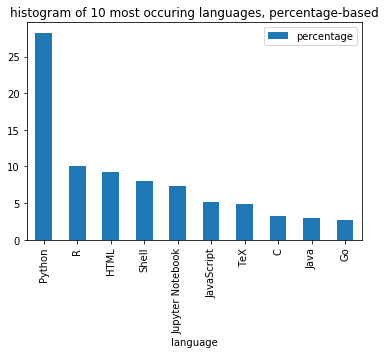

In [268]:
value_count_licenses  = repos["language"].value_counts().head(10)
percentage_count_licences = [[language, value_count/repos["language"].value_counts().sum()*100] for value_count,language in zip(value_count_licenses,value_count_licenses.keys())]
percentage_pd = pd.DataFrame(percentage_count_licences, columns = ['language','percentage'])
percentage_pd  = percentage_pd.set_index('language')
percentage_pd.plot(kind='bar', title='histogram of 10 most occuring languages, percentage-based')
plt.savefig(export_path_graphs + "languages_percentages.png" ,bbox_inches="tight")


## relative occurence languages

In [41]:
sum_five = 0
times = 0
for key,i in zip(repos["language"].value_counts().keys(), repos["language"].value_counts()):
    print(key)
    print(i/sum(repos["language"].value_counts()))
    sum_five += i/sum(repos["language"].value_counts())
    times += 1
    if times ==10:
        break
    
    
print(sum_five)

Python
0.2826825127334465
R
0.100169779286927
HTML
0.09252971137521222
Shell
0.08064516129032258
Jupyter Notebook
0.0730050933786078
JavaScript
0.05178268251273345
TeX
0.04923599320882852
C
0.03225806451612903
Java
0.029711375212224108
Go
0.027164685908319185
0.8191850594227504


## The following percentages represent the percentage of repositories that contains that specific language for the 10 most occuring languages:

In [157]:
for value, language in zip(languages["language"].value_counts().head(10), languages["language"].value_counts().head(10).keys()):
    percentage = value / len(repos) * 100
    print("{} is present in {:.2f} % of all repositories". format(language, percentage))

Python is present in 37.02 % of all repositories
Shell is present in 23.82 % of all repositories
HTML is present in 18.22 % of all repositories
R is present in 16.08 % of all repositories
JavaScript is present in 10.99 % of all repositories
CSS is present in 9.88 % of all repositories
TeX is present in 9.44 % of all repositories
Jupyter Notebook is present in 8.55 % of all repositories
Makefile is present in 7.74 % of all repositories
C++ is present in 6.86 % of all repositories


## correlation table top 10 languages

In [252]:
languages["language"].value_counts().head(10).keys()
dict_languages_user = Counter()
for language in languages["language"].value_counts().head(10).keys():
    dict_top_languages[language] = 0

In [253]:
dict_users = {}

In [254]:

for html_url in repos['html_url']: 
    #print(html_url)
    rows_language_for_one_user = languages.loc[languages['html_url_repository'] == html_url]
    dict_languages_user = Counter()
    for language in languages["language"].value_counts().head(10).keys(): #set all values of languages that need to be present to create a dataset in a later stage to zero
        dict_languages_user[language] = 0
    for language in rows_language_for_one_user['language']:
        if language in dict_languages_user: #only count languages in the top 10
            dict_languages_user[language] += 1
    dict_users[html_url] = dict_languages_user #each user has a dict with 10 booleans representing whether the top 10 language is present in their repo or not


In [255]:
languages_per_repo = pd.DataFrame.from_dict(dict_users, orient = 'index')

In [257]:
languages_per_repo.corr().round(decimals = 2)

Python  Shell  HTML     R  JavaScript   CSS   TeX  \
Python              1.00   0.18 -0.04 -0.15       -0.03  0.01 -0.10   
Shell               0.18   1.00 -0.00 -0.05       -0.00  0.05 -0.01   
HTML               -0.04  -0.00  1.00  0.18        0.52  0.56  0.17   
R                  -0.15  -0.05  0.18  1.00       -0.04  0.06  0.23   
JavaScript         -0.03  -0.00  0.52 -0.04        1.00  0.63 -0.00   
CSS                 0.01   0.05  0.56  0.06        0.63  1.00  0.15   
TeX                -0.10  -0.01  0.17  0.23       -0.00  0.15  1.00   
Jupyter Notebook    0.13  -0.01 -0.00 -0.03       -0.07 -0.04  0.04   
Makefile            0.13   0.18  0.06  0.02        0.01  0.03  0.17   
C++                 0.09   0.18  0.01  0.01        0.01 -0.01  0.03   

                  Jupyter Notebook  Makefile   C++  
Python                        0.13      0.13  0.09  
Shell                        -0.01      0.18  0.18  
HTML                         -0.00      0.06  0.01  
R                            -0.03      0.02  0.01  
JavaScript                   -0.07      0.01  0.01  
CSS                          -0.04      0.03 -0.01  
TeX                           0.04      0.17  0.03  
Jupyter Notebook              1.00      0.02 -0.05  
Makefile                      0.02      1.00  0.43  
C++                          -0.05      0.43  1.00

## Topics

Topics describe the context of the repository. 

In [42]:
topics['topic'].value_counts().nlargest(50)

genomics                      26
utrecht-university            20
python                        19
yoda                          16
bioinformatics                15
stan                          15
irods                         11
nim-lang                      11
php                           10
james-server                  10
r                              9
r-package                      9
codeigniter                    8
machine-learning               8
growth-curves                  8
bayesian                       8
nim                            8
fiji-plugin                    7
growth-charts                  7
anthropometry                  6
bayesian-data-analysis         6
asreview                       6
high-throughput-sequencing     5
mice                           5
dataset                        5
imagej                         5
mcmc                           5
dutch                          5
golang                         5
nodejs                         5
plotting  

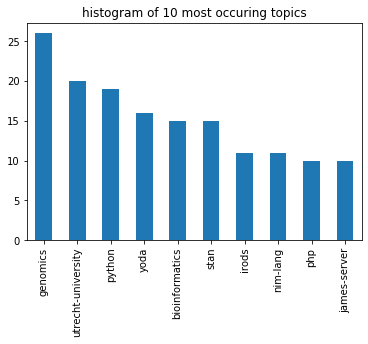

In [43]:
topics['topic'].value_counts().nlargest(10).plot(kind = 'bar', title = 'histogram of 10 most occuring topics')
plt.savefig(export_path_graphs + '/10_most_occuring_topics.png')

## number of  contributors

The number of contributors gives information on how many people put effort into the repository. Theoratically, it would make sense if a higher amount of contributors implied a more FAIR repository, because those are easier to find in a registery and work on because of their license. 


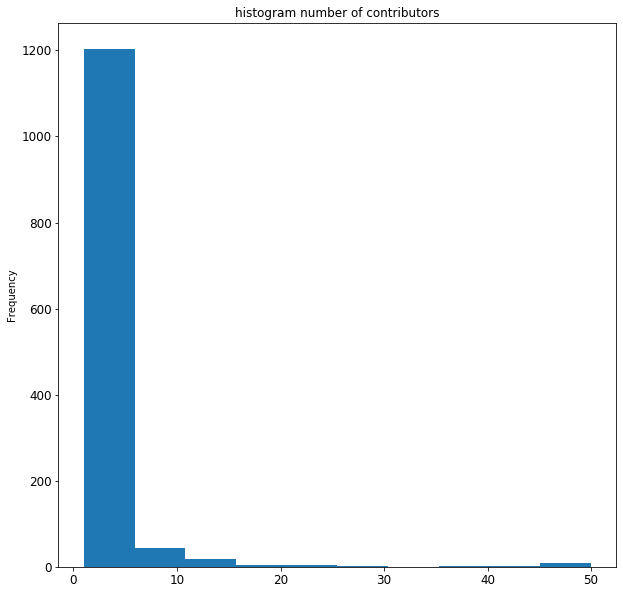

In [44]:
contributors['html_url_repository'].value_counts().plot(kind = 'hist' ,x = 'contributors', figsize = (10,10), fontsize = 12, title = 'histogram number of contributors')
plt.savefig(export_path_graphs + '/contributors.png')


In [45]:
contributors['html_url_repository'].value_counts().nlargest(20, keep = 'all')


https://github.com/stan-dev/math                              50
https://github.com/stan-dev/example-models                    50
https://github.com/stan-dev/rstan                             50
https://github.com/stan-dev/monostan                          50
https://github.com/aldertzomer/Microbial-Genomics-2020        50
https://github.com/aldertzomer/Microbial-Genomics-2019        50
https://github.com/stan-dev/stan                              50
https://github.com/stan-dev/docs                              47
https://github.com/leonardovida/gatsby-starter-netlify-cms    43
https://github.com/stan-dev/pystan2                           39
https://github.com/OceanParcels/parcels                       37
https://github.com/stan-dev/cmdstan                           29
https://github.com/stan-dev/cmdstanpy                         29
https://github.com/brentp/cyvcf2                              26
https://github.com/stan-dev/rstanarm                          24
https://github.com/stan-d

In [46]:
print('mean contributors: {:.2f}'.format(statistics.mean(contributors['html_url_repository'].value_counts())))
print('median contributors: {}'.format(statistics.median(contributors['html_url_repository'].value_counts())))

mean contributors: 2.43
median contributors: 1


## Howfairis sum score descriptives and correlations

In this section, the median and meand of the howfairis sum score is shown, as well as correlations the how fair is sum score, the amount of contributors and the amount of months since the last commit

In [61]:
how_fair_sum_scores = []
for index, row in how_fair_is.iterrows():
    how_fair_is_sum = row['howfairis_repository'] + row['howfairis_license'] +row['howfairis_registry'] + row['howfairis_citation'] + row['howfairis_checklist']
    how_fair_sum_scores.append(how_fair_is_sum)

mean: 1.60
median: 2.0


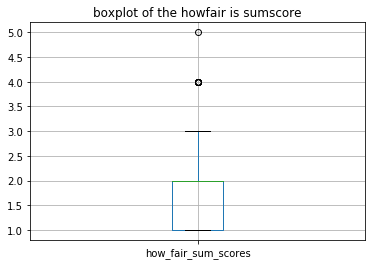

In [62]:
how_fair_is['how_fair_sum_scores'] = how_fair_sum_scores
print("mean: {:.2f}".format(statistics.mean(how_fair_sum_scores)))
print("median: {}".format(statistics.median(how_fair_sum_scores)))
pd.DataFrame((statistics.mean(how_fair_sum_scores), statistics.median(how_fair_sum_scores)),["mean", "median"])
how_fair_is.boxplot(column = 'how_fair_sum_scores')
plt.title('boxplot of the howfair is sumscore')
plt.savefig(export_path_graphs + '/howfairissum_boxplot.png')


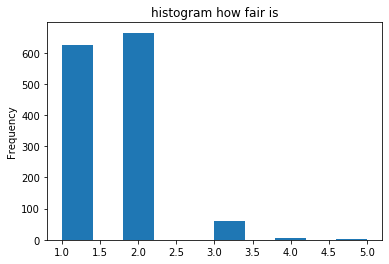

In [63]:
how_fair_is['how_fair_sum_scores'].plot(kind = 'hist', title = 'histogram how fair is')
plt.savefig(export_path_graphs + '/howfairissum_histogram.png')


In [64]:
correlation_df = pd.DataFrame()

In [65]:
correlation_df['how_fair_sum_scores'] = how_fair_sum_scores
correlation_df['contributions']= contributors['contributions']
correlation_df['months_ago_most_recent_commit'] = repos['months_ago_most_recent_commit']

In [66]:
correlation_df.corr(method='pearson').round(decimals=2)

how_fair_sum_scores  contributions  \
how_fair_sum_scores                           1.00           0.00   
contributions                                 0.00           1.00   
months_ago_most_recent_commit                -0.23          -0.01   

                               months_ago_most_recent_commit  
how_fair_sum_scores                                    -0.23  
contributions                                          -0.01  
months_ago_most_recent_commit                           1.00

## Binary correlation plot between howfairis variables

A correlation table that shows the correlation between the howfairis measures.

In [67]:
correlation_how_fair_is = pd.DataFrame()

#correlation_how_fair_is['howfairis_repository'] = how_fair_is['howfairis_repository']
correlation_how_fair_is['howfairis_license'] = how_fair_is['howfairis_license']
correlation_how_fair_is['howfairis_registry'] = how_fair_is['howfairis_registry']
correlation_how_fair_is['howfairis_citation'] = how_fair_is['howfairis_citation']
correlation_how_fair_is['howfairis_checklist'] = how_fair_is['howfairis_checklist']



In [68]:
correlation_how_fair_is.corr(method='pearson').round(decimals=2) #howfairis_repository is all true, so has no variance

howfairis_license  howfairis_registry  \
howfairis_license                 1.00                0.09   
howfairis_registry                0.09                1.00   
howfairis_citation                0.10                0.08   
howfairis_checklist               0.05                0.24   

                     howfairis_citation  howfairis_checklist  
howfairis_license                  0.10                 0.05  
howfairis_registry                 0.08                 0.24  
howfairis_citation                 1.00                 0.13  
howfairis_checklist                0.13                 1.00

## Programming language and Howfairis

Different programming languages need different licences. For some languages (e.g. python), these are more complex. How does this influence the HowFairis score?

In [69]:
languages['language'].value_counts().nlargest(10)

Python              502
Shell               323
HTML                247
R                   218
JavaScript          149
CSS                 134
TeX                 128
Jupyter Notebook    116
Makefile            105
C++                  93
Name: language, dtype: int64

In [70]:
index_how_fair_is = 0
language_how_fair_is_df = []
#get a list with the how-fair-is scores added to the language dataset
for index,row in languages.iterrows():
    if how_fair_is['html_url'][index_how_fair_is] != languages['html_url_repository'][index]:
        index_how_fair_is += 1 
    sum_score = how_fair_is['how_fair_sum_scores'][index_how_fair_is]
    language_how_fair_is_df.append(sum_score)
regression_data_how_fair_is_language = pd.DataFrame()
language_data_dummies = pd.get_dummies(languages['language'])  #one hot-encoding for language dataset
regression_data_how_fair_is_language['how_fair_is_sum'] = language_how_fair_is_df
languages['how_fair_sum_scores'] = regression_data_how_fair_is_language #add scores to language dataset

In [71]:
train_size = int(len(languages) * 0.8) #training size is 2227, testing size is  557
regression_how_fair_is_language_train_X = language_data_dummies[:train_size]
regression_how_fair_is_language_train_y = regression_data_how_fair_is_language['how_fair_is_sum'][:train_size]
regression_how_fair_is_language_test_X = language_data_dummies[train_size:]
regression_how_fair_is_language_test_y = regression_data_how_fair_is_language['how_fair_is_sum'][train_size:]

In [72]:
#train regression
regression_language_how_fair_is = LinearRegression()
regression_language_how_fair_is.fit(regression_how_fair_is_language_train_X, regression_how_fair_is_language_train_y)

# Make predictions using the testing set
language_how_fair_is_y_pred = regression_language_how_fair_is.predict(regression_how_fair_is_language_test_X)

# The coefficients
#print('Coefficients: \n', regression_language_how_fair_is.coef_)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(regression_how_fair_is_language_test_y, language_how_fair_is_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(regression_how_fair_is_language_test_y, language_how_fair_is_y_pred))


Mean squared error: 1377381701137258329931776.00
Coefficient of determination: -2929495005183538869829632.00


In [73]:
language_subset = language_data_dummies[['Python', 'Shell', 'R', 'JavaScript', 'HTML']] #top 5 languages


In [74]:
train_size = int(len(language_subset) * 0.8)
regression_how_fair_is_language_train_X = language_subset[:train_size]
regression_how_fair_is_language_train_y = regression_data_how_fair_is_language['how_fair_is_sum'][:train_size]
regression_how_fair_is_language_test_X = language_subset[train_size:]
regression_how_fair_is_language_test_y = regression_data_how_fair_is_language['how_fair_is_sum'][train_size:]

In [75]:
#train regression
regression_language_how_fair_is = LinearRegression()
regression_language_how_fair_is.fit(regression_how_fair_is_language_train_X, regression_how_fair_is_language_train_y)

# Make predictions using the testing set
language_how_fair_is_y_pred = regression_language_how_fair_is.predict(regression_how_fair_is_language_test_X)

# The coefficients
print('Coefficients: \n', regression_language_how_fair_is.coef_)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(regression_how_fair_is_language_test_y, language_how_fair_is_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(regression_how_fair_is_language_test_y, language_how_fair_is_y_pred))


Coefficients: 
 [-0.00806049  0.04545234 -0.01923682 -0.04352009 -0.0493532 ]
Mean squared error: 0.47
Coefficient of determination: 0.00


A simple regression for predicting the how fair is score from  all or a subset of languages does not seem to yield any results 

## Examples of high howfairis scores 

In this section, some links to the pages that have a high howfairis score are shown. 

In [76]:
how_fair_is_high_scores = how_fair_is[how_fair_is['how_fair_sum_scores'] > 3]

how_fair_is_high_scores['html_url']

15            https://github.com/cjvanlissa/worcs
19             https://github.com/cjvanlissa/bain
175     https://github.com/J535D165/recordlinkage
191          https://github.com/asreview/asreview
239               https://github.com/CLARIAH/grlc
1059        https://github.com/puregome/notebooks
1157      https://github.com/haddocking/pdb-tools
1302      https://github.com/D-score/childdevdata
Name: html_url, dtype: object

## Re-use of other projects and articles

Are there competitors?
How do they relate to each other?